# Analytics
## Luis Natera
natera@hey.com

## Library imports

For the data cleanning and manipulation section I will use pandas, matplotlib for the visualizations, scipy for performing the comparison between groups.

In [182]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind_from_stats
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [37]:
df = pd.read_csv('../data/processed/users_activities.csv',index_col=0)
df['days_since_reg'] = pd.to_timedelta(df['days_since_reg'])

## In this dataset men generated a higher week 1 revenue than women, on average.

1. Is this difference in revenue between men and women statistically significant?
2. What is an appropriate statistical test to determine this and what is it's p-value

To check the difference and determine if this is statistical significant we can use a ttest to compare the two distributions. But first we need to aggregate by the gender and the first week.

In [40]:
def get_df_revenue(df_week):
    df_revenue = pd.DataFrame()
    df_revenue['observations'] = df_week.groupby('Gender').count()['UserId']
    df_revenue['mean_revenue'] = df_week.groupby('Gender')['Revenue'].mean()
    df_revenue['std_revenue'] = df_week.groupby('Gender')['Revenue'].std()
    return df_revenue

In [41]:
df_week = df[df['days_since_reg'] < pd.Timedelta(7, unit='days')]
df_revenue = get_df_revenue(df_week)

tstat, pvalue = ttest_ind_from_stats(df_revenue.at['M','mean_revenue'], df_revenue.at['M','std_revenue'], df_revenue.at['M','observations'], df_revenue.at['F','mean_revenue'], df_revenue.at['F','std_revenue'], df_revenue.at['F','observations'])

pvalue

0.02134216828880289

As the p-values is less than 0.05 (p-value = 0.021) we can say that the difference between the revenue by men and women is statistical significant.

## In which country is this difference biggest?

In [79]:
df_country = pd.DataFrame(df_week.groupby(['Country','Gender']).sum()['Revenue'].reset_index()).pivot(index='Country',columns=['Gender'],values=['Revenue'])
df_country.columns = df_country.columns.get_level_values(1)
df_country['difference'] = df_country['M'] - df_country['F']
df_country['times_difference'] =  df_country['M'] / df_country['F']
df_country.sort_values('difference',ascending=False)

Gender,F,M,difference,times_difference
Country,,,,
GB,125557.29,356309.30,230752.01,2.837822
US,26926.68,143615.87,116689.19,5.333590
DE,18591.98,100383.13,81791.15,5.399271
FR,14183.16,88368.19,74185.03,6.230501
Other,14025.21,76329.92,62304.71,5.442337


The biggest difference in absolute revenue is in GB, where males in week 1 made 23,0752.01 more than women. However, in France alotugh the absolute numbers are not as high as in GB, the difference between male and women is quite high, with males having a revenue 6.2 times larger than women.

## Please visualize the relationship between country, gender, and week 1 revenue with an appropriate chart.

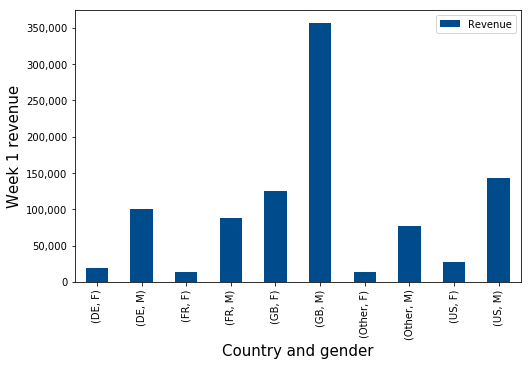

In [104]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
pd.DataFrame(df_week.groupby(['Country','Gender']).sum()['Revenue']).plot(kind='bar',ax=ax,color='#004B8C')
ax.set_xlabel('Country and gender', fontsize=15)
ax.set_ylabel('Week 1 revenue', fontsize=15)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


## Build a linear regression model to predict the week 1 revenue of a user based on the following variables:

- Gender,
- Age,
- Country,
- day 1 revenue (ie the revenue generated by the user on their registration date).
 
 Which of these variables have a statistically significant predictive power according to this model?

### Get the necesary data.

Use the users information and combine it with the revenue generated by the activities information to build the dataset that will be used for the model.

In [151]:
df_users = pd.read_csv('../data/raw/users.csv')
df_users['Gender'] = df_users['Gender'].replace(r'^\s*$', 'M', regex=True)
df_users.loc[:,'DOB'] = pd.to_datetime(df_users['DOB'])
now = pd.Timestamp('now')
df_users['age'] = (now - df_users['DOB']).astype('<m8[Y]').astype(int)

In [187]:
df_model = pd.DataFrame()
df_model['Revenue_Week1'] = df_week.groupby(['UserId'])['Revenue'].sum()
df_model['Day_1_revenue'] = df_week[df_week['days_since_reg'] < pd.Timedelta(1, unit='days')].groupby('UserId')['Revenue'].sum()
df_model['Day_1_revenue'].fillna(0,inplace=True)
df_model = df_model.merge(df_users,left_index=True,right_on='UserId')
df_model = df_model[['Revenue_Week1','Gender','age','Country','Day_1_revenue']]

LE_country = LabelEncoder()
df_model['Country_code'] = LE.fit_transform(df_model['Country'])

LE_Gender = LabelEncoder()
df_model['Gender_code'] = LE.fit_transform(df_model['Gender'])

In [188]:
X = df_model.drop(['Revenue_Week1','Gender','Country'],axis=1).values
y = df_model['Revenue_Week1'].values

In [189]:
X

array([[35.  ,  0.  ,  2.  ,  0.  ],
       [43.  ,  0.  ,  3.  ,  1.  ],
       [53.  ,  0.  ,  2.  ,  1.  ],
       ...,
       [33.  , 30.  ,  2.  ,  1.  ],
       [26.  , 17.05,  4.  ,  0.  ],
       [27.  , 42.63,  4.  ,  1.  ]])

In [161]:
y

array([20.  , 29.19, 20.  , ..., 30.  , 17.05, 42.63])